In [14]:
import numpy as np
from pathlib import Path
import pandas as pd
import torch
from matplotlib import pyplot as plt

from src.models.normal import NormalDegradationModel as NModel
from src.models.particle_filter import ParticleFilterModel,ParticleFilterMLP

In [15]:
data_name = "DS03"
perform_name = 'SmHPC'

device = "cpu"
experiment_dir = Path('experiments')/data_name
pf_dir = experiment_dir/'pf_perform'
checkpoint_path = pf_dir / perform_name / "checkpoint.pt"
checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

## Import training data

In [16]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')

### get only degraded data

In [17]:
hi_df = hi_df[hi_df['hs']==0]
del hi_df['hs']

In [18]:
perform_alias = [col for col in hi_df.columns if col not in ['unit','cycle']]
units = hi_df['unit'].astype(int).unique().tolist()
units

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [19]:
performs_train = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in units} 
    for name in perform_alias
}
time_train = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Create component (base) models

In [20]:
eval_data = {}
eval_eol = {}
for unit in units:
    t_data = time_train[unit]
    s_data = performs_train[perform_name][unit]
    eval_data[unit]=torch.tensor(np.stack([t_data, s_data],axis=1),dtype=torch.float32).to(device)
    eval_eol[unit]=torch.tensor(t_data[-1],dtype=torch.float32) 


In [21]:
train_degmodels = {}
for eval_unit in units:
    degmodels=[]
    for unit, perform in performs_train[perform_name].items():
        if unit == eval_unit:
            continue
        best_model = NModel()
        best_model.load_state_dict(
            torch.load(experiment_dir/'states'/perform_name/f'unit_{unit}'/ "best_model.pt", map_location=device)
        )
        best_model.to(device)
        degmodels.append(best_model)
    train_degmodels[eval_unit] = degmodels

## Train Particle Filter Net

In [22]:
n_particles = 1600
multiply_scale = 0.05
start_idx = 5 

n_epochs = 5000
acc_epochs = 1

In [23]:
net = ParticleFilterMLP(state_dim=5, hidden_dims=[128, 128, 32]).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer.zero_grad()

In [24]:
start_epoch = 0
best_loss = float("inf")
total_loss = 0.0
losses = []
epochs = []

if checkpoint_path.exists():
    ckpt = torch.load(checkpoint_path, map_location=device)

    net.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])

    start_epoch = ckpt["epoch"] + 1
    best_loss = ckpt["best_loss"]
    losses = ckpt["losses"]
    epochs = ckpt["epochs"]

    print(f"✓ Resumed from epoch {start_epoch}, best_loss={best_loss:.3f}")

In [ ]:
for epoch in range(start_epoch,n_epochs):

    epoch_loss = 0.0
    n_loss = 0
    for eval_unit in units:
        degmodels = train_degmodels[eval_unit]
        t_data = eval_data[eval_unit][:, 0]
        s_data = eval_data[eval_unit][:, 1]

        pf = ParticleFilterModel(
            base_models=degmodels,
            net=net,
            max_life=100.0,
            n_particles=n_particles,
            multiply_scale=multiply_scale,
            name=perform_name,
        ).train()

        for k in range(start_idx, len(t_data)):
            mixture_dist = pf.step(
                t_obs=t_data[:k],
                s_obs=s_data[:k],
            )
            last_dist = mixture_dist.distribution(s=s_data[[-1]])
            nll = -last_dist.log_prob(t_data[[-1]]).mean()

            epoch_loss += nll
            n_loss += 1

    # ---- normalize THIS epoch’s contribution ----
    epoch_loss = epoch_loss / n_loss

    # ---- accumulate gradient ----
    total_loss += epoch_loss

    # ---- step every acc_epochs ----
    if (epoch + 1) % acc_epochs == 0:
        total_loss /= acc_epochs
        total_loss.backward()
        optimizer.step()
        
        current_loss = total_loss.item()
        print(f"[Epoch {epoch:04d}] loss = {current_loss:.3f}")
        losses.append(current_loss)
        epochs.append(epoch)
        
        # ---- save best model ----
        if current_loss < best_loss:
            best_loss = current_loss
            
            checkpoint ={
				'epoch': epoch,
				'model_state':net.state_dict(),
				'optimizer_state': optimizer.state_dict(),
				'best_loss': best_loss,
				'losses': losses,
				'epochs': epochs,
			}
            torch.save(checkpoint,checkpoint_path)
            print("  + saved ")
            
        ## Reset
        
        optimizer.zero_grad()
        total_loss = 0.0

[Epoch 0000] loss = 3.748
  + saved 
[Epoch 0001] loss = 3.729
  + saved 
[Epoch 0002] loss = 3.740
[Epoch 0003] loss = 3.741
[Epoch 0004] loss = 3.727
  + saved 
[Epoch 0005] loss = 3.742
[Epoch 0006] loss = 3.743
[Epoch 0007] loss = 3.739
[Epoch 0008] loss = 3.743
[Epoch 0009] loss = 3.736
[Epoch 0010] loss = 3.736
[Epoch 0011] loss = 3.765
[Epoch 0012] loss = 3.749
[Epoch 0013] loss = 3.753
[Epoch 0014] loss = 3.752
[Epoch 0015] loss = 3.752
[Epoch 0016] loss = 3.734
[Epoch 0017] loss = 3.729
[Epoch 0018] loss = 3.691
  + saved 
[Epoch 0019] loss = 3.740
[Epoch 0020] loss = 3.757
[Epoch 0021] loss = 3.741
[Epoch 0022] loss = 3.723
[Epoch 0023] loss = 3.729
[Epoch 0024] loss = 3.705
[Epoch 0025] loss = 3.741
[Epoch 0026] loss = 3.723
[Epoch 0027] loss = 3.711
[Epoch 0028] loss = 3.687
  + saved 
[Epoch 0029] loss = 3.713


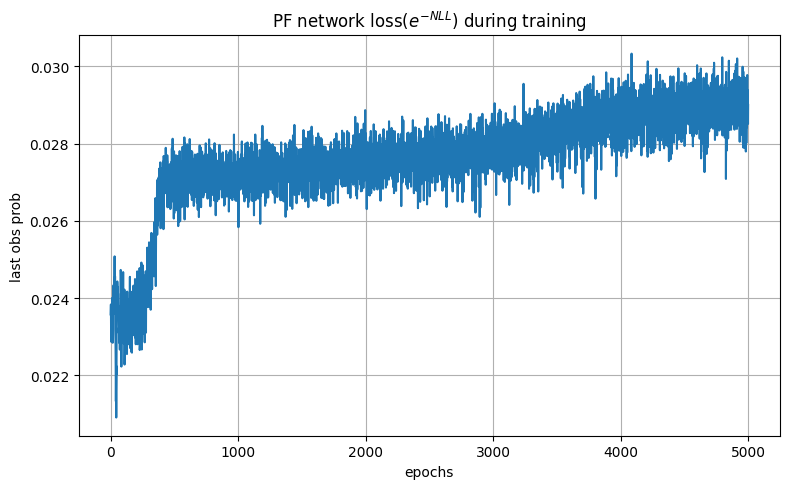

In [ ]:
likelihood = np.exp(-np.array(losses))

plt.figure(figsize=(8, 5))
plt.plot(epochs, likelihood)
plt.xlabel('epochs')
plt.ylabel('last obs prob')
plt.title('PF network loss($e^{-NLL}$) during training')
plt.grid(True)

plt.tight_layout()
plt.savefig(pf_dir /perform_name/"net_training_loss.png", dpi=300) 
np.save(pf_dir /perform_name/"net_training_loss.npy", np.array(losses))
plt.show()